In [38]:
# ─── Cell 1: Imports & Hyperparameters ────────────────────────────────────
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import random

# 1) Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 2) Hyperparameters
data_size_to_train = 10_000   # if you want to slice; else use full text
seq_len           = 200       # context length
hidden_size       = 256       # RNN hidden dimension
num_layers        = 2         # number of LSTM layers
learning_rate     = 1e-5
batch_size        = 128
num_epochs        = 100


Using device: cuda


In [39]:
# ─── Cell 2: Load Text & Build Vocabulary ────────────────────────────────
with open('integrated.txt','r',encoding='utf-8') as f:
    full_text = f.read()

# Choose full text or first N chars:
data = full_text
# data = full_text[:data_size_to_train]

characters = sorted(set(data))
vocab_size = len(characters)
print(f"Data has {len(data)} chars, {vocab_size} unique")

# Mappings
char_to_idx = {ch: i for i, ch in enumerate(characters)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}


Data has 82383 chars, 79 unique


In [40]:
# ─── Cell 3: Encode & Split into Train/Val ───────────────────────────────
# Integer-encode full sequence
data_nums = [char_to_idx[c] for c in data]

# 90% train / 10% validation
split      = int(0.9 * len(data_nums))
train_nums = data_nums[:split]
val_nums   = data_nums[split:]

print(f"Train size: {len(train_nums)}, Val size: {len(val_nums)}")


Train size: 74144, Val size: 8239


In [41]:
# ─── Cell 4: Dataset & DataLoader ────────────────────────────────────────
class SequenceDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data    = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(
            self.data[idx:idx+self.seq_len], dtype=torch.long
        )
        y = torch.tensor(
            self.data[idx+1:idx+self.seq_len+1], dtype=torch.long
        )
        return x, y

train_dataset = SequenceDataset(train_nums, seq_len)
val_dataset   = SequenceDataset(val_nums,   seq_len)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
val_loader   = DataLoader(
    val_dataset,   batch_size=batch_size
)


In [42]:
# ─── Cell 5: CharRNN Model Definition ────────────────────────────────────
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.embedding   = nn.Embedding(vocab_size, hidden_size)
        self.lstm        = nn.LSTM(
            hidden_size, hidden_size, num_layers,
            batch_first=True
        )
        self.fc          = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        # x: [batch, seq_len]
        emb = self.embedding(x)                  # [batch, seq_len, hidden]
        out, hidden = self.lstm(emb, hidden)     # out: [batch, seq_len, hidden]
        out = self.fc(out)                       # [batch, seq_len, vocab]
        return out, hidden

    def init_hidden(self, batch_size):
        # (h0, c0) each: [num_layers, batch, hidden_size]
        weight = next(self.parameters())
        return (
            weight.new_zeros(self.num_layers, batch_size, self.hidden_size),
            weight.new_zeros(self.num_layers, batch_size, self.hidden_size)
        )

model = CharRNN(vocab_size, hidden_size, num_layers).to(device)


In [43]:
# ─── Cell 6: Sampling & Evaluation Utilities ─────────────────────────────
def sample_char(logits, temperature=1.0, top_k=None):
    # logits: 1D tensor of size vocab_size
    if top_k is not None:
        vals, idxs = torch.topk(logits, top_k)
        mask = torch.full_like(logits, float('-inf'))
        mask[idxs] = vals
        logits = mask
    scaled = logits.div(temperature)
    probs  = F.softmax(scaled, dim=0)
    return torch.multinomial(probs, 1).item()

def generate(model, start, length=200, temperature=0.5, top_k=8):
    model.eval()
    hidden = model.init_hidden(1)
    # prime with all but last char
    for ch in start[:-1]:
        _, hidden = model(
            torch.tensor([[char_to_idx[ch]]], device=device), hidden
        )
    # last char to get initial out
    out, hidden = model(
        torch.tensor([[char_to_idx[start[-1]]]], device=device), hidden
    )
    result = start
    for _ in range(length):
        logits = out.squeeze()         # [vocab_size]
        idx    = sample_char(logits, temperature, top_k)
        ch     = idx_to_char[idx]
        result += ch
        if ch in '.?!':               # stop at sentence end
            break
        out, hidden = model(
            torch.tensor([[idx]], device=device), hidden
        )
    return result

def evaluate(model, data_nums, criterion, seq_len):
    model.eval()
    total_loss = 0.0
    hidden = model.init_hidden(1)
    count  = 0
    with torch.no_grad():
        for i in range(0, len(data_nums)-seq_len, seq_len):
            x = torch.tensor([data_nums[i:i+seq_len]], device=device)
            y = torch.tensor([data_nums[i+1:i+seq_len+1]], device=device)
            out, hidden = model(x, hidden)
            hidden = tuple(h.detach() for h in hidden)
            loss = criterion(
                out.view(-1, vocab_size),
                y.view(-1)
            )
            total_loss += loss.item()
            count += 1
    return total_loss / count


In [44]:
# ─── Cell 7: Training Loop with Validation, Logging & Sampling ──────────
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses   = []

for epoch in range(1, num_epochs+1):
    model.train()
    epoch_loss = 0.0
    hidden = model.init_hidden(batch_size)

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        hidden = tuple(h.detach() for h in hidden)

        optimizer.zero_grad()
        out, hidden = model(x_batch, hidden)
        loss = criterion(out.view(-1, vocab_size), y_batch.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    val_loss   = evaluate(model, val_nums, criterion, seq_len)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch:2d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss:   {val_loss:.4f} | "
        f"Val PPL:    {math.exp(val_loss):.2f}"
    )

    # ── Generate a sample from a random starting character ────────────────
    start_char = random.choice(characters)
    sample = generate(
        model,
        start=start_char,
        length=200,
        temperature=0.5,
        top_k=8
    )
    print(f" Sample [{start_char!r}]: {sample}\n")


Epoch  1 | Train Loss: 3.5638 | Val Loss:   3.0731 | Val PPL:    21.61
 Sample ['W']: W)3oisn en taa s a ie  tanoh   ti t o  t he   taa  en  ee  e    eioo  tohht at  a e a  a ne tao ha han e   a e   ethaon   eito  eoto o     eei teeeo  este t h  ate  tha  ta   e toa    a a a o a  e  e  

Epoch  2 | Train Loss: 2.9960 | Val Loss:   2.9122 | Val PPL:    18.40
 Sample ['3']: 3mn sese on e ean oho e te he the hin h at aaa os ee ot e  ete oo ao o thiet teero oa t eeoo n eo eo ea tiat teh te no  one  ho eo t oo te t eee e a e tite e oo  ee haae ae  oo on eee h ti o inn a ehao



KeyboardInterrupt: 

In [ ]:
# ─── Cell 8: Sample a Sentence ─────────────────────────────────────────────
print("\n-- Sample Generation --")
print(
    generate(
        model,
        start="B",
        length=300,
        temperature=0.5,
        top_k=8
    )
)



-- Sample Generation --
B fasd were down the macle and siction to as coring thail siples of the tore anderist wich as thing I manle sitind wal stide that he same daden wes hore sast of wall cofe core ming there sated wo surt a that in the salle there in ang mere solimes, of there was in thai st calle straly.


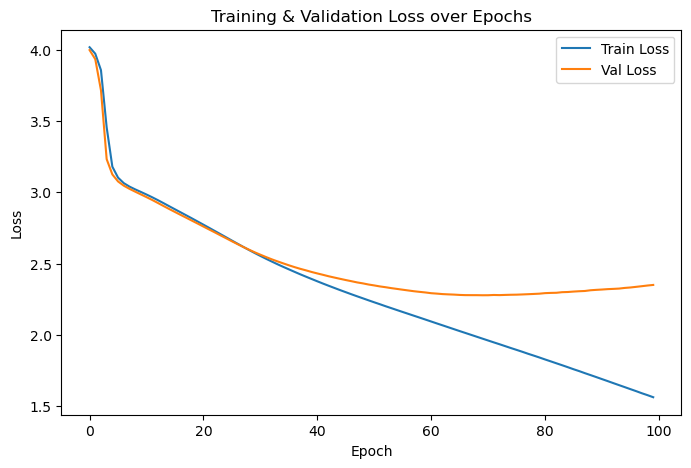

In [ ]:
# ─── Cell 8: Plot Learning Curves ────────────────────────────────────────
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.show()
